## Code_Changes_Git
This is the reference implementation for [Code_Changes](https://github.com/chaoss/wg-evolution/blob/master/metrics/Code_Changes.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Code_Changes
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Examples of how to check for specific peculiarities of git commits

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `scripts` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `../..` to `sys.path`, so that `scripts` can be successfully imported. 

In [48]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../..')

from implementations.scripts.utils import read_json_file
from implementations.scripts.conditions import (MergeExclude, 
                                                MasterInclude, 
                                                PostfixExclude,
                                                EmptyExclude,
                                                CommitByTag)
from implementations.scripts.commit_git import CommitGit

In [49]:
class CodeChangesGit(CommitGit):
    """
    Class for Code_Changes for Git repositories. (non-pandas)
    """

    def compute(self):
        """
        Count number of commits of different types, like including
        empty commits or counting only those commits made on
        the master branch.

        :returns count: the number of commits satisfying the conditions passed
            while instantiating CodeChangesGit.
        """

        commit_hashes = {item['hash'] for item in self.items}
        return len(commit_hashes)

### Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 
For starters, we can perform a simple count of all commits in the file. To make things simple, we will use the `Naive` implementation for deciding whether a given commit affects the source code or not. Again, the naive implementation assumes that all files are part of the source code, and hence, all commits are considered to affect it. The `Naive` implementation is the default option. 

### Counting the total number of commits 
We first read the JSON file containing Perceval data using the `read_json_file` utility function.

In [50]:
items = read_json_file('../git-commits.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.

In [51]:
changes = CodeChangesGit(items)
print("The total number of commits "
      "in the file is {}.".format(changes.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")    

changes_dated = CodeChangesGit(items,
                        date_range=(date_since, date_until))
                        
print("The total number of commits between "
      "2018-01-01 and 2018-07-01 is {}.".format(changes_dated.compute()))

The total number of commits in the file is 1963.
The total number of commits between 2018-01-01 and 2018-07-01 is 437.


### Counting the total number of commits excluding merge commits
Moving on, lets make use of the `EmptyExclude` and `MergeExclude` classes to filter out empty and merge commits respectively. These classes are sub-classes of the `Commit` class in the `conditions` module. They provide two methods: `check()` and `set_commits`.

The `set_commits` method selects commits which satisfy a given condition (like excluding empty commits, for example) and stores the hashes of those commits in the set `included`, an instance variable of all `Commit` classes. 

The `check()` method checks each commit in the dictionary created from Perceval data and drops those rows which correspond to commits not in `included`. 

### Counting the total number of commits only made on the master branch
Another option one has while using this class for analyzing git commit data is to include only those commits for analysis which are on the master branch. To do this, we pass in an object of the `MasterInclude` class as a list to the conds parameter while instantiating the `CodeChangesGit` class.

We compute the number of commits created on the master branch after `2018-01-01`, which we stored in the `datetime` object, `date_since`.

In [52]:
changes_only_master = CodeChangesGit(items,
                                    date_range=(date_since, None),
                                    conds=[MasterInclude()])

print("The total number of commits made on the master branch "
      "after 2018-01-01 is {}.".format(changes_only_master.compute()))

The total number of commits made on the master branch after 2018-01-01 is 571.


Lets do one last thing: the same thing we did in the cell above, but without including empty commits. In this case, we would also need to pass a `EmptyExclude` object of `conditions` module to conds.

Also, lets exclude those commits which work solely on markdown files. We use the `PostfixExclude` class in `conditions` module, a sub-class of `Code` for this.

In [53]:
changes_non_empty_master = CodeChangesGit(items,
                                          is_code=[PostfixExclude(postfixes=['.md'])],
                                          conds=[MasterInclude(), EmptyExclude()])

print("The total number of non-empty commits made on the master branch is: {}".format(changes_non_empty_master.compute()))

The total number of non-empty commits made on the master branch is: 47


### Counting commits with a specific tag in their message
If the project has a guideline for the writing of the message of commits, we have the possibility to classify these commits. For example, if the code changes in a commit correct a bug, then the message of this commit can be `"[FIX] add path into sys.path to include correctly scripts for metrics"`. With the `[FIX]` tag, we can count the number of commits for the bug fixes.

In `git-commits.json` file, some commits have these next tags into their message: `[api]` and `[backend]`.

In [54]:
tags = ["[api]", "[backend]"]
result = []
for tag in tags:
    code_changes = CodeChangesGit(items, conds=[CommitByTag(tag)]).compute()
    result.append(code_changes)
    print("Code_Changes, only for the commits "
          "whose their message starts with {}: {}".format(tag, code_changes))

Code_Changes, only for the commits whose their message starts with [api]: 53
Code_Changes, only for the commits whose their message starts with [backend]: 48


With this classification, we can compare the number of commits by tags.

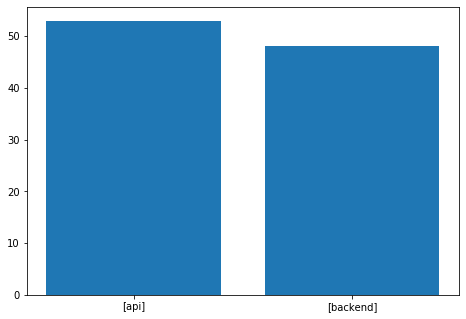

In [55]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tags, result)
plt.show()